# Potato Disease Classification

Dataset https://www.kaggle.com/arjuntejaswi/plant-village

### Import all the Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os

### Set all the Constants

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=20

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Assuming 'Datasets' directory is in your home directory
home_directory = os.path.expanduser("~")
# Using raw string
dataset_directory = os.path.join(home_directory, r"/content/drive/MyDrive/AML/PlantVillage")

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_directory,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 2152 files belonging to 3 classes.


In [ ]:
classes = dataset.class_names
classes

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels

### Visualize some of the images from our dataset

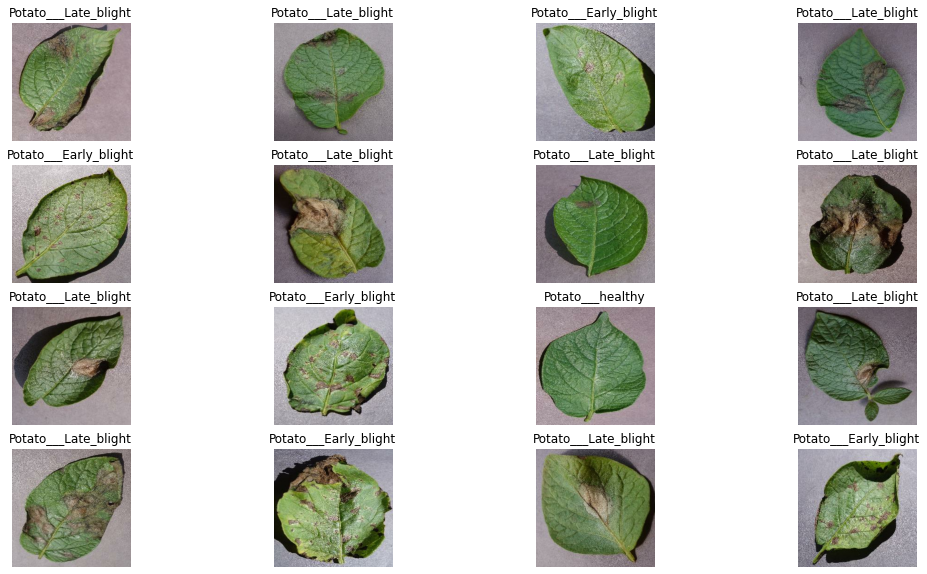

In [ ]:
plt.figure(figsize=(18, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(classes[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset


In [ ]:
len(dataset)

68

In [26]:
def split_data(ds, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [27]:
train_ds, val_ds, test_ds = split_data(dataset)

### Cache, Shuffle, and Prefetch the Dataset

In [28]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Now we try to build a model that learns invariances in the data , we do this by training the model with original unaugmented images and  test it on shuffled images

In [44]:
import os
from PIL import Image
import numpy as np

def crop(image_data, height, width, area):
    image_data = (image_data * 255).astype(np.uint8)

    im = Image.fromarray(image_data)
    imgwidth, imgheight = im.size
    patches = []
    for i in range(0, imgheight, height):
        for j in range(0, imgwidth, width):
            box = (j, i, j+width, i+height)
            a = im.crop(box)
            try:
                o = a.crop(area)
                patches.append(np.array(o))  # Append the cropped patch as numpy array
            except:
                pass
    return patches

# Parameters for cropping and transformation
height = IMAGE_SIZE // 2  # Height of each patch
width = IMAGE_SIZE // 2   # Width of each patch
area = (0, 0, width, height)  # Crop area for each patch

# Function to shuffle the patches and concatenate them back into a single image
def shuffle_and_concatenate_patches(patches):
    np.random.shuffle(patches)  # Shuffle the patches
    rows = cols = 2  # Assuming 4 patches
    reconstructed_image = np.zeros((rows * height, cols * width, 3))  # Initialize reconstructed image
    idx = 0
    for i in range(rows):
        for j in range(cols):
            reconstructed_image[i*height:(i+1)*height, j*width:(j+1)*width] = patches[idx]
            idx += 1
    return reconstructed_image



## Define the Models

In [39]:
import tensorflow as tf

class PatchModel_16_patch(tf.keras.Model):
    def __init__(self):
        super(PatchModel_16_patch, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(16, kernel_size=3, padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')
        self.pool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(16, activation='relu')
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.fc2 = tf.keras.layers.Dense(3, activation='softmax')  # Assuming 3 classes for the new data

    def call(self, inputs):
    # Assuming the input x is a shuffled image of size (batch_size, 256, 256, 3)
    # and the patches are of size (batch_size, 128, 128, 3)

    # We first split the image into 4 patches along the width and height dimensions
      patches = tf.split(inputs, num_or_size_splits=2, axis=1)
      patches = [tf.split(patch, num_or_size_splits=2, axis=2) for patch in patches]
      patches = [item for sublist in patches for item in sublist]  # Flatten list of patches

      patch_outputs = []
      for patch in patches:
          patch_out = self.pool(self.conv1(patch))
          patch_out = self.flatten(patch_out)
          patch_out = self.fc1(patch_out)
          patch_out = self.dropout(patch_out)
          patch_out = self.fc2(patch_out)
          patch_outputs.append(patch_out)

      all_patch_outputs = tf.stack(patch_outputs, axis=1)  # Shape: (batch_size, 4, 3)

      final_prediction = tf.reduce_mean(all_patch_outputs, axis=1)  # Shape: (batch_size, 3)

      return final_prediction


In [72]:
import tensorflow as tf
from tensorflow.keras import layers as Layers

class CIFAR10ShuffleInvariantModel(tf.keras.Model):
    def __init__(self):
        super(CIFAR10ShuffleInvariantModel, self).__init__()
        self.conv1 = Layers.Conv2D(64, kernel_size=4, strides=4, activation='relu')
        self.conv2 = Layers.Conv2D(128, kernel_size=2, strides=2, activation='relu')
        self.conv3 = Layers.Conv2D(256, kernel_size=1, strides=1, activation='relu')
        self.bn = Layers.BatchNormalization()
        self.pool = Layers.AveragePooling2D(pool_size=4)
        self.flatten = Layers.Flatten()
        self.fc1 = Layers.Dense(512, activation='relu')
        self.fc2 = Layers.Dense(256, activation='relu')
        self.fc3 = Layers.Dense(128, activation='relu')
        self.classifier = Layers.Dense(3, activation='softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.bn(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.classifier(x)
        return x


In [40]:
# Instantiate the model
model = PatchModel_16_patch()

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Fit the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    batch_size=32
)

Epoch 1/20
47/47 [==============================] - 78s 1s/step - loss: 1.9188 - accuracy: 0.4500 - val_loss: 9.1133 - val_accuracy: 0.4281
Epoch 2/20
47/47 [==============================] - 48s 1s/step - loss: 1.7703 - accuracy: 0.4649 - val_loss: 9.2175 - val_accuracy: 0.4281
Epoch 3/20
47/47 [==============================] - 48s 1s/step - loss: 1.5956 - accuracy: 0.4514 - val_loss: 9.2175 - val_accuracy: 0.4281
Epoch 4/20
47/47 [==============================] - 50s 1s/step - loss: 1.5987 - accuracy: 0.4595 - val_loss: 9.2175 - val_accuracy: 0.4281
Epoch 5/20
47/47 [==============================] - 46s 982ms/step - loss: 1.5136 - accuracy: 0.4662 - val_loss: 9.2175 - val_accuracy: 0.4281
Epoch 6/20
47/47 [==============================] - 50s 1s/step - loss: 1.6478 - accuracy: 0.4595 - val_loss: 9.2175 - val_accuracy: 0.4281
Epoch 7/20
47/47 [==============================] - 48s 1s/step - loss: 1.6576 - accuracy: 0.4669 - val_loss: 9.2175 - val_accuracy: 0.4281
Epoch 8/20
47/47 

#Test data Shuffling

first we create shuffled test data which have images split in 4 patches and are shuffled

In [90]:
def transform_test_ds(test_ds, height, width, area):
    transformed_images = []
    labels_list = []
    for images, labels in test_ds:
        for image, label in zip(images.numpy(), labels.numpy()):
            patches = crop(image, height, width, area)
            shuffled_image = shuffle_and_concatenate_patches(patches)
            transformed_images.append(shuffled_image)
            labels_list.append(label)

    transformed_images = np.array(transformed_images)
    labels_list = np.array(labels_list)

    return transformed_images, labels_list

height = IMAGE_SIZE // 2
width = IMAGE_SIZE // 2
area = (0, 0, width, height)
transformed_images, transformed_labels = transform_test_ds(test_ds, height, width, area)


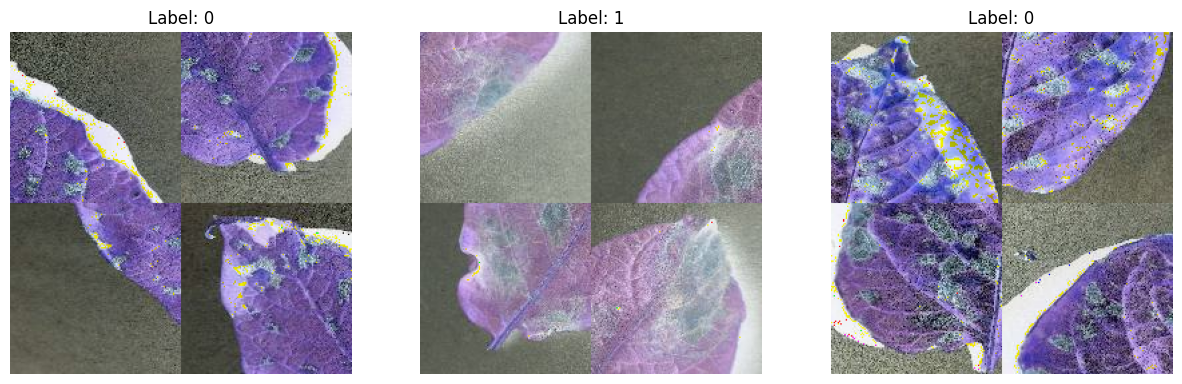

In [91]:
import matplotlib.pyplot as plt

# Define a function to display images with their labels
def display_images(images, labels, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        axes[i].imshow(images[i].astype(np.uint8))
        axes[i].set_title(f'Label: {labels[i]}')
        axes[i].axis('off')
    plt.show()

# Display some images from transformed_images along with their labels
num_images_to_display = 3
display_images(transformed_images, transformed_labels, num_images=num_images_to_display)

Test on normal test_ds

In [60]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_ds)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


11/11 [==============================] - 3s 316ms/step - loss: 8.7962 - accuracy: 0.4543
Test Loss: 8.796154975891113
Test Accuracy: 0.45426830649375916


Test on shuffled test_ds

In [69]:

# Evaluate the model
test_loss, test_accuracy = model.evaluate(transformed_images, transformed_labels)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


11/11 [==============================] - 6s 537ms/step - loss: 8.7962 - accuracy: 0.4543
Test Loss: 8.796156883239746
Test Accuracy: 0.45426830649375916


##--Write insights--

In [ ]:
# Instantiate the model
# Instantiate the model
model = CIFAR10ShuffleInvariantModel()

# Call build to create the model's weights
model.build((None, IMAGE_SIZE, IMAGE_SIZE, 3))

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Now you can call model.summary()
model.summary()



In [79]:
# Fit the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    batch_size=32
)

Epoch 1/10
47/47 [==============================] - 37s 792ms/step - loss: 0.0333 - accuracy: 0.9966 - val_loss: 0.0387 - val_accuracy: 0.9937
Epoch 2/10
47/47 [==============================] - 35s 752ms/step - loss: 0.0252 - accuracy: 0.9980 - val_loss: 0.0298 - val_accuracy: 0.9969
Epoch 3/10
47/47 [==============================] - 35s 752ms/step - loss: 0.0192 - accuracy: 1.0000 - val_loss: 0.0235 - val_accuracy: 0.9969
Epoch 4/10
47/47 [==============================] - 37s 788ms/step - loss: 0.0173 - accuracy: 1.0000 - val_loss: 0.0292 - val_accuracy: 0.9969
Epoch 5/10
47/47 [==============================] - 37s 786ms/step - loss: 0.0145 - accuracy: 1.0000 - val_loss: 0.0174 - val_accuracy: 1.0000
Epoch 6/10
47/47 [==============================] - 37s 792ms/step - loss: 0.0119 - accuracy: 1.0000 - val_loss: 0.0173 - val_accuracy: 0.9969
Epoch 7/10
47/47 [==============================] - 35s 753ms/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 0.0148 - val_accuracy: 1.0000

In [80]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_ds)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


11/11 [==============================] - 2s 151ms/step - loss: 0.0185 - accuracy: 0.9970
Test Loss: 0.018455499783158302
Test Accuracy: 0.9969512224197388


In [81]:
height = IMAGE_SIZE // 2
width = IMAGE_SIZE // 2
area = (0, 0, width, height)
transformed_images, transformed_labels = transform_test_ds(test_ds, height, width, area)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(transformed_images, transformed_labels)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

11/11 [==============================] - 2s 164ms/step - loss: 1.4532 - accuracy: 0.5732
Test Loss: 1.4531670808792114
Test Accuracy: 0.5731707215309143


##--Write insights--

##Let's see how resolution , image size affect model performance

We do this by resizing the images to 32x32

In [84]:
# resize train_ds , val_ds and test_ds to 32x32
train_ds_resized = train_ds.map(lambda x, y: (tf.image.resize(x, (32, 32)), y))
val_ds_resized = val_ds.map(lambda x, y: (tf.image.resize(x, (32, 32)), y))
test_ds_resized = test_ds.map(lambda x, y: (tf.image.resize(x, (32, 32)), y))

model = CIFAR10ShuffleInvariantModel()
model.build((None, 32, 32, 3))
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history = model.fit(
    train_ds_resized,
    validation_data=val_ds_resized,
    epochs=50,
    batch_size=32
)


Epoch 1/50
47/47 [==============================] - 5s 21ms/step - loss: 1.1005 - accuracy: 0.3912 - val_loss: 1.0580 - val_accuracy: 0.4750
Epoch 2/50
47/47 [==============================] - 1s 18ms/step - loss: 0.9947 - accuracy: 0.5926 - val_loss: 1.0257 - val_accuracy: 0.4281
Epoch 3/50
47/47 [==============================] - 1s 18ms/step - loss: 0.9055 - accuracy: 0.7392 - val_loss: 1.0256 - val_accuracy: 0.4344
Epoch 4/50
47/47 [==============================] - 1s 18ms/step - loss: 0.8265 - accuracy: 0.7750 - val_loss: 0.9839 - val_accuracy: 0.4750
Epoch 5/50
47/47 [==============================] - 1s 20ms/step - loss: 0.7567 - accuracy: 0.7838 - val_loss: 0.9147 - val_accuracy: 0.5375
Epoch 6/50
47/47 [==============================] - 1s 18ms/step - loss: 0.6968 - accuracy: 0.7865 - val_loss: 0.8272 - val_accuracy: 0.6062
Epoch 7/50
47/47 [==============================] - 1s 18ms/step - loss: 0.6477 - accuracy: 0.7926 - val_loss: 0.7305 - val_accuracy: 0.6750
Epoch 8/50
47

#**Needs to be implemented!!!**

#Bhanu end

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size.
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.1, 0.1),
    layers.experimental.preprocessing.RandomTranslation(0.1, 0.1),
    layers.experimental.preprocessing.RandomContrast(0.1),
])

#### Applying Data Augmentation to Train Dataset

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30


54/54 [==============================] - 40s 688ms/step - loss: 0.9147 - accuracy: 0.4635 - val_loss: 0.8756 - val_accuracy: 0.4688
Epoch 2/30
54/54 [==============================] - 36s 671ms/step - loss: 0.7927 - accuracy: 0.6157 - val_loss: 0.5786 - val_accuracy: 0.7708
Epoch 3/30
54/54 [==============================] - 37s 674ms/step - loss: 0.6865 - accuracy: 0.7089 - val_loss: 0.5261 - val_accuracy: 0.7865
Epoch 4/30
54/54 [==============================] - 39s 726ms/step - loss: 0.4859 - accuracy: 0.8084 - val_loss: 1.0194 - val_accuracy: 0.5365
Epoch 5/30
54/54 [==============================] - 37s 678ms/step - loss: 0.4556 - accuracy: 0.8235 - val_loss: 0.3623 - val_accuracy: 0.8646
Epoch 6/30
54/54 [==============================] - 38s 693ms/step - loss: 0.3986 - accuracy: 0.8293 - val_loss: 0.6377 - val_accuracy: 0.7500
Epoch 7/30
54/54 [==============================] - 37s 689ms/step - loss: 0.3531 - accuracy: 0.8461 - val_loss: 0.4662 - val_accuracy: 0.79

In [ ]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 1s 98ms/step - loss: 0.1575 - accuracy: 0.9453


**You can see above that we get 94% accuracy for our test dataset. This is considered to be a pretty good accuracy**

In [ ]:
scores

[0.15748639404773712, 0.9453125]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

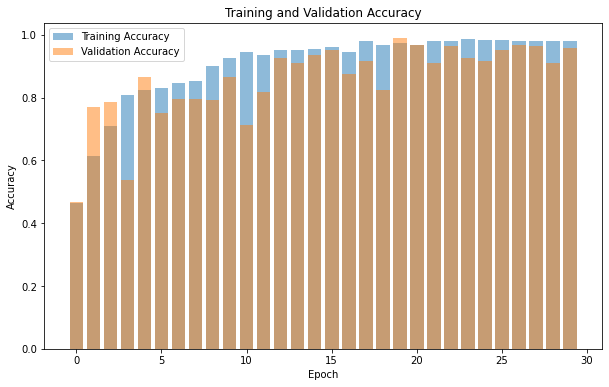

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.bar(range(len(acc)), acc, label='Training Accuracy', alpha=0.5)
plt.bar(range(len(val_acc)), val_acc, label='Validation Accuracy', alpha=0.5)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


### Using only RandomFlip("horizontal_and_vertical") and RandomRotation(0.2) for Data Augmentation

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

# Applying Data Augmentation to Train Dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Architecture
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model2 = models.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

# Compile the Model
model2.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Train the Model
history = model2.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)


Epoch 1/30
54/54 [==============================] - 40s 703ms/step - loss: 0.8899 - accuracy: 0.5052 - val_loss: 0.8403 - val_accuracy: 0.5208
Epoch 2/30
54/54 [==============================] - 41s 742ms/step - loss: 0.6753 - accuracy: 0.6910 - val_loss: 0.7842 - val_accuracy: 0.7396
Epoch 3/30
54/54 [==============================] - 39s 712ms/step - loss: 0.5065 - accuracy: 0.7951 - val_loss: 0.7813 - val_accuracy: 0.7812
Epoch 4/30
54/54 [==============================] - 39s 715ms/step - loss: 0.4636 - accuracy: 0.8090 - val_loss: 0.7680 - val_accuracy: 0.7396
Epoch 5/30
54/54 [==============================] - 40s 727ms/step - loss: 0.3671 - accuracy: 0.8536 - val_loss: 1.2617 - val_accuracy: 0.6927
Epoch 6/30
54/54 [==============================] - 39s 713ms/step - loss: 0.4647 - accuracy: 0.8194 - val_loss: 0.6039 - val_accuracy: 0.7188
Epoch 7/30
54/54 [==============================] - 39s 714ms/step - loss: 0.3444 - accuracy: 0.8721 - val_loss: 0.5559 - val_accuracy: 0.7917

In [ ]:
scores_2 = model2.evaluate(test_ds)

8/8 [==============================] - 1s 123ms/step - loss: 0.4164 - accuracy: 0.8828


In [ ]:
scores_2

[0.4163523316383362, 0.8828125]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
print(history.history.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


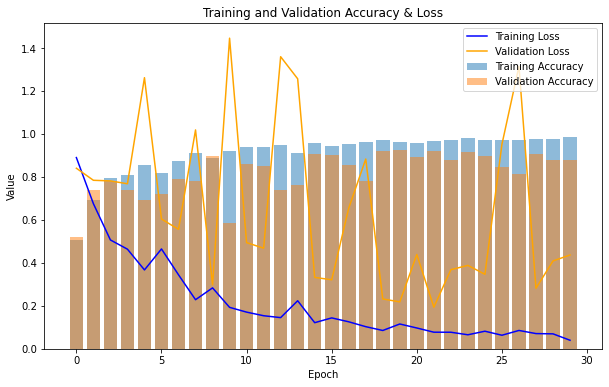

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot accuracy
plt.bar(range(len(acc)), acc, label='Training Accuracy', alpha=0.5)
plt.bar(range(len(val_acc)), val_acc, label='Validation Accuracy', alpha=0.5)

# Plot loss
plt.plot(range(len(loss)), loss, label='Training Loss', color='blue')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss', color='orange')

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training and Validation Accuracy & Loss')
plt.legend()
plt.show()


 By analyzing these plots, you can assess how well your model is learning from the training data and whether it's overfitting or underfitting. If the training accuracy is significantly higher than the validation accuracy and the training loss continues to decrease while the validation loss starts to increase, it may indicate overfitting, where the model is memorizing the training data but not generalizing well to new data. If both training and validation accuracy/loss are improving steadily, it suggests that the model is learning effectively.

Conclusion:

In this scenario, Model 1, with more augmentation techniques, performs better than Model 2, suggesting that the additional augmentations are beneficial for improving the model's performance and generalization capabilities.

The results highlight the importance of carefully selecting and incorporating effective augmentation techniques into the training pipeline to enhance the performance of machine learning models, particularly in image processing tasks where data augmentation can play a crucial role in improving model robustness and generalization.

### Running prediction on a sample image

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 1s 929ms/step
predicted label: Potato___Late_blight


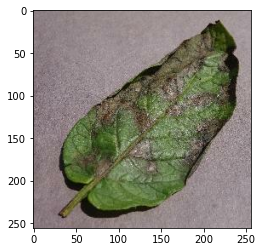

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model2.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Function for inference

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model2.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 [==============================] - 0s 40ms/step


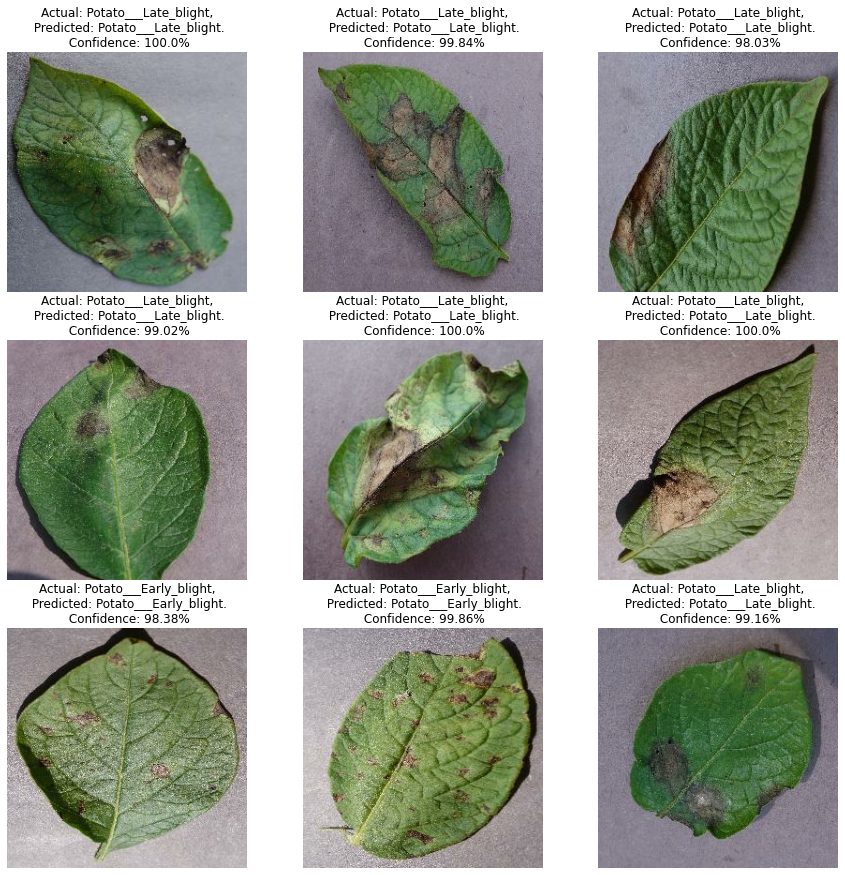

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model2, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

# Experimenting with the pre-trained CNN (ResNet 50) for feature extraction and train a classifier (SVM) to classify images of potato diseases.

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Define function to extract features using pre-trained model
def extract_features(dataset, base_model):
    feature_list = []
    label_list = []
    for image_batch, labels_batch in dataset:
        # Preprocess input images
        preprocessed_images = preprocess_input(image_batch)
        # Extract features using the base model
        features = base_model.predict(preprocessed_images)
        # Append features and labels to lists
        feature_list.append(features)
        label_list.append(labels_batch)
    # Concatenate features and labels
    features_concatenated = tf.concat(feature_list, axis=0)
    labels_concatenated = tf.concat(label_list, axis=0)
    return features_concatenated, labels_concatenated

# Assuming 'Datasets' directory is in your home directory
home_directory = os.path.expanduser("~")
# Using raw string
dataset_directory = os.path.join(home_directory, r"C:\Users\pc\Downloads\image processing research 2", "PlantVillage")

# Load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_directory,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

# Define the base model (ResNet50)
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
)

# Extract features from the dataset using the base model
features, labels = extract_features(dataset, base_model)

# Flatten the features
features_flattened = tf.reshape(features, (features.shape[0], -1))

# Convert TensorFlow tensors to NumPy arrays
features_array = features_flattened.numpy()
labels_array = labels.numpy()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_array, labels_array, test_size=0.2, random_state=42)


Found 2152 files belonging to 3 classes.
1/1 [==============================] - 1s 1s/step


In [ ]:
# Train the SVM classifier
classifier = SVC(kernel='linear', random_state=42)
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate the classifier
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       208
           1       0.98      0.99      0.99       194
           2       0.96      0.86      0.91        29

    accuracy                           0.99       431
   macro avg       0.98      0.95      0.97       431
weighted avg       0.99      0.99      0.99       431



### Looking at this report model is performing good and lets do validation score

In [ ]:
from sklearn.model_selection import cross_val_score

# Define your SVM classifier
classifier = SVC(kernel='linear', random_state=42)

# Perform cross-validation with 5 folds
cv_scores = cross_val_score(classifier, features_array, labels_array, cv=5)

# Print the cross-validation scores
print("Cross-validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())


Cross-validation Scores: [0.99303944 0.99303944 0.99534884 0.98372093 0.99069767]
Mean CV Score: 0.9911692656342741


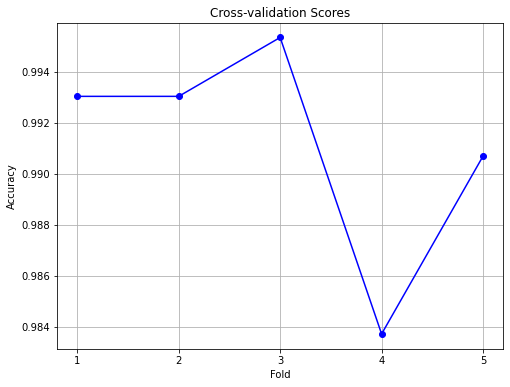

In [ ]:
# Plot the cross-validation scores
plt.figure(figsize=(8, 6))
plt.plot(range(1, 6), cv_scores, marker='o', linestyle='-', color='b')
plt.title('Cross-validation Scores')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.xticks(range(1, 6))
plt.grid(True)
plt.show()

Yes, those cross-validation scores look quite good! The mean cross-validation score of approximately 0.991 suggests that your model performs consistently well across different subsets of the data. This indicates that your model's performance is robust and less likely to be influenced by specific train-test splits. Therefore, you can have more confidence in the generalization performance of your classifier.